accordion
 #### Reading image category  accordion  ##### 
C:\Python37\opencv\Scripts\Assignment3\bovw\images\train
Reading file  C:\Python37\opencv\Scripts\Assignment3\bovw\images\train\accordion\image_0001.jpg
Reading file  C:\Python37\opencv\Scripts\Assignment3\bovw\images\train\accordion\image_0002.jpg
Reading file  C:\Python37\opencv\Scripts\Assignment3\bovw\images\train\accordion\image_0003.jpg
Reading file  C:\Python37\opencv\Scripts\Assignment3\bovw\images\train\accordion\image_0007.jpg
Reading file  C:\Python37\opencv\Scripts\Assignment3\bovw\images\train\accordion\image_0008.jpg
Reading file  C:\Python37\opencv\Scripts\Assignment3\bovw\images\train\accordion\image_0009.jpg
Reading file  C:\Python37\opencv\Scripts\Assignment3\bovw\images\train\accordion\image_0010.jpg
Reading file  C:\Python37\opencv\Scripts\Assignment3\bovw\images\train\accordion\image_0011.jpg
Reading file  C:\Python37\opencv\Scripts\Assignment3\bovw\images\train\accordion\image_0012.jpg
Reading file  C:\Pyth

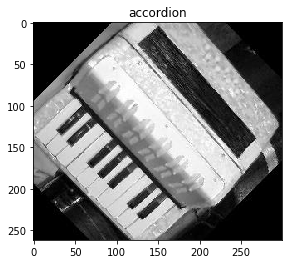

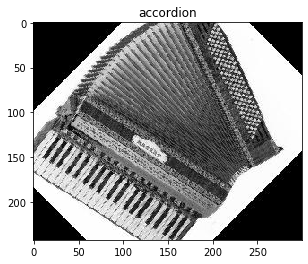

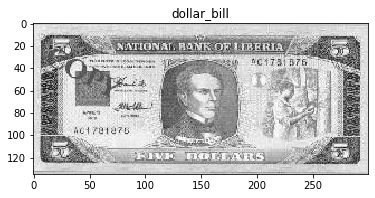

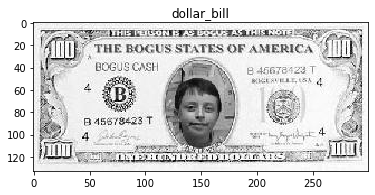

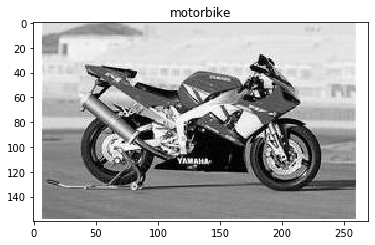

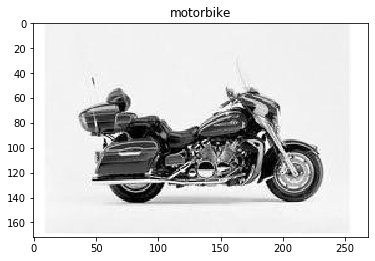

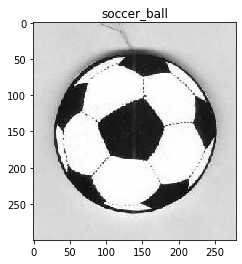

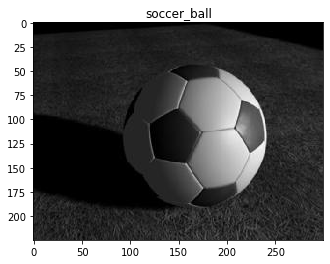

In [19]:
import cv2 as cv
import numpy as np 
from glob import glob 
import argparse
from helpers import *
from matplotlib import pyplot as plt 


class BagOfVisualWords:
    def __init__(self, no_clusters):
        self.no_clusters = no_clusters
        self.train_path = None
        self.test_path = None
        self.im_helper = ImageHelpers()
        self.bovw_helper = BOVWHelpers(no_clusters)
        self.file_helper = FileHelpers()
        self.images = None
        self.trainImageCount = 0
        self.train_labels = np.array([])
        self.name_dict = {}
        self.descriptor_list = []

    def trainModel(self):
        """
        This method contains the entire module 
        required for training the bag of visual words model

        Use of helper functions will be extensive.

        """

        # read file. prepare file lists.
        self.images, self.trainImageCount = self.file_helper.getFiles(self.train_path)
        # extract SIFT Features from each image
        label_count = 0 
        for word, imlist in self.images.items():
            self.name_dict[str(label_count)] = word
            print("Computing features for ", word)
            for im in imlist:
                cv.imshow("im", im)
                cv.waitKey(100)
                self.train_labels = np.append(self.train_labels, label_count)
                kp, des = self.im_helper.features(im)
                self.descriptor_list.append(des)

            label_count += 1


        # perform clustering
        bov_descriptor_stack = self.bovw_helper.formatND(self.descriptor_list)
        self.bovw_helper.cluster()
        self.bovw_helper.developVocabulary(n_images = self.trainImageCount, descriptor_list=self.descriptor_list)

        # show vocabulary trained
        # self.bov_helper.plotHist()
 

        self.bovw_helper.standardize()
        self.bovw_helper.train(self.train_labels)


    def recognize(self,test_img, test_image_path=None):

        """ 
        This method recognizes a single image 
        It can be utilized individually as well.


        """

        kp, des = self.im_helper.features(test_img)
        # print kp
        print(des.shape)

        # generate vocab for test image
        vocab = np.array( [[ 0 for i in range(self.no_clusters)]])
        # locate nearest clusters for each of 
        # the visual word (feature) present in the image
        
        # test_ret =<> return of kmeans nearest clusters for N features
        test_ret = self.bovw_helper.kmeans_obj.predict(des)
        # print test_ret

        # print vocab
        for each in test_ret:
            vocab[0][each] += 1

        print(vocab)
        # Scale the features
        vocab = self.bovw_helper.scale.transform(vocab)

        # predict the class of the image
        lb = self.bovw_helper.clf.predict(vocab)
        # print "Image belongs to class : ", self.name_dict[str(int(lb[0]))]
        return lb



    def testModel(self):
        """ 
        This method is to test the trained classifier

        read all images from testing path 
        use BOVHelpers.predict() function to obtain classes of each image

        """

        self.testImages, self.testImageCount = self.file_helper.getFiles(self.test_path)

        predictions = []
        classification=[]
        predicts=[]

        for word, imlist in self.testImages.items():
            print("processing " ,word)
            for im in imlist:
                classification.append(word)
                # print imlist[0].shape, imlist[1].shape
                print (im.shape)
                cl = self.recognize(im)
                print (cl)
                predictions.append({
                    'image':im,
                    'class':cl,
                    'object_name':self.name_dict[str(int(cl[0]))]
                    })
                predicts.append(self.name_dict[str(int(cl[0]))])
                
        print (predictions)
        print ('classifications:',classification)
        print ('predictions:',predicts)
        
        for each in predictions:
            # cv.imshow(each['object_name'], each['image'])
            # cv.waitKey()
            # cv.destroyWindow(each['object_name'])
            # 
            plt.imshow(cv.cvtColor(each['image'], cv.COLOR_GRAY2RGB))
            plt.title(each['object_name'])
            plt.show()


    def print_vars(self):
        pass


if __name__ == '__main__':

    # parse cmd args
    #parser = argparse.ArgumentParser(
    description=" Bag of visual words example"
        
    #parser.add_argument(r'C:\Python37\opencv\Scripts\Assignment3\bovw\images\train')
    #parser.add_argument(r'C:\Python37\opencv\Scripts\Assignment3\bovw\images\test')

    #args = vars(parser.parse_args())
    #print(args)

    bovw = BagOfVisualWords(no_clusters=100)

    # set training paths
    bovw.train_path = r'C:\Python37\opencv\Scripts\Assignment3\bovw\images\train'
    # set testing paths
    bovw.test_path = r'C:\Python37\opencv\Scripts\Assignment3\bovw\images\test'
    # train the model
    bovw.trainModel()
    # test model
    bovw.testModel()

    

In [12]:
import cv2 as cv
import numpy as np
from glob import glob
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt


class ImageHelpers:
    def __init__(self):
        #self.sift_object = cv.xfeatures2d.SIFT_create()
        self.surf_object = cv.xfeatures2d.SIFT_create()


    def gray(self, image):
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        return gray

    def features(self, image):
        #keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
        keypoints, descriptors = self.surf_object.detectAndCompute(image, None)
        return [keypoints, descriptors]




class BOVWHelpers:
    def __init__(self, n_clusters=20):
        self.n_clusters = n_clusters
        self.kmeans_obj = KMeans(n_clusters=n_clusters)
        self.kmeans_ret = None
        self.descriptor_vstack = None
        self.mega_histogram = None
        self.clf = SVC()

    def cluster(self):
        """
        cluster using KMeans algorithm,

        """
        self.kmeans_ret = self.kmeans_obj.fit_predict(self.descriptor_vstack)


    def developVocabulary(self, n_images, descriptor_list, kmeans_ret=None):

        """
        Each cluster denotes a particular visual word
        Every image can be represeted as a combination of multiple
        visual words. The best method is to generate a sparse histogram
        that contains the frequency of occurence of each visual word

        Thus the vocabulary comprises of a set of histograms of encompassing
        all descriptions for all images

        """

        self.mega_histogram = np.array([np.zeros(self.n_clusters) for i in range(n_images)])
        old_count = 0
        for i in range(n_images):
            l = len(descriptor_list[i])
            for j in range(l):
                if kmeans_ret is None:
                    idx = self.kmeans_ret[old_count + j]
                else:
                    idx = kmeans_ret[old_count + j]
                self.mega_histogram[i][idx] += 1
            old_count += l
        print("Vocabulary Histogram Generated")

    def standardize(self, std=None):
        """

        standardize is required to normalize the distribution
        wrt sample size and features. If not normalized, the classifier may become
        biased due to steep variances.

        """
        if std is None:
            self.scale = StandardScaler().fit(self.mega_histogram)
            self.mega_histogram = self.scale.transform(self.mega_histogram)
        else:
            print("STD not none. External STD supplied")
            self.mega_histogram = std.transform(self.mega_histogram)

    def formatND(self, l):
        """
        restructures list into vstack array of shape
        M samples x N features for sklearn

        """
        vStack = np.array(l[0])
        for remaining in l[1:]:
            vStack = np.vstack((vStack, remaining))
        self.descriptor_vstack = vStack.copy()
        return vStack

    def train(self, train_labels):
        """
        uses sklearn.svm.SVC classifier (SVM)


        """
        print("Training SVM")
        print(self.clf)
        print("Train labels", train_labels)
        self.clf.fit(self.mega_histogram, train_labels)
        print("Training completed")

    def predict(self, iplist):
        predictions = self.clf.predict(iplist)
        return predictions

    def plotHist(self, vocabulary=None):
        print("Plotting histogram")
        if vocabulary is None:
            vocabulary = self.mega_histogram

        x_scalar = np.arange(self.n_clusters)
        y_scalar = np.array([abs(np.sum(vocabulary[:, h], dtype=np.int32)) for h in range(self.n_clusters)])

        print(y_scalar)

        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Complete Vocabulary Generated")
        plt.xticks(x_scalar + 0.4, x_scalar)
        plt.show()


class FileHelpers:

    def __init__(self):
        pass

    def getFiles(self, path: object) -> object:
        """
        - returns  a dictionary of all files
        having key => value as  objectname => image path

        - returns total number of files.

        """
        imlist = {}
        count = 0
        for each in glob(path + "\\*"):
            word = each.split("\\")[-1]
            print(word)
            print(" #### Reading image category ", word, " ##### ")
            imlist[word] = []
            print(path)
            for imagefile in glob(path + "\\" + word + "\\*"):
                print("Reading file ", imagefile)
                im = cv.imread(imagefile, 0)
                imlist[word].append(im)
                count += 1

        print("[imlist, count]", imlist, count)
        return [imlist, count]


[1 0 1 0 1 2 2 0 2 0 1 0 2 0 2 0 0 0 0 2 2 2 0 1 2 0 2 1 0 1 0 0 1 2 2 0 1
 2 1 0 0 1 1 2 0 0 2 2 1 1 1 0 2 2 0 1 0 2 1 2 2 2 0 1 2 1 0 1 0 1 0 1 2 0
 0 1 0 1 2 2 2 0 2 2 0 1 1 2 2 1 0 0 0 0 1 1 1 2 0 0 2 2 1 1 0 2 0 2 2 0 1
 1 2 0 0 2 1 2 1 0 0 2 2 2 2 1 0 2 2 2 1 1 1 1 1 2 0 1 1 2 0 1 1 0 1 2 2 1
 1 2 2 2 0 0 2 0 1 0 1 0 1 1 2 1 2 2 2 1 1 1 2 2 2 1 1 2 2 2 0 1 1 2 2 0 2
 0 0 2 1 1 0 2 2 2 1 0 2 0 0 2 1 0 0 0 1 1 0 0 0 1 0 0 1 1 2 1 0 0 2 1 1 2
 2 0 1 1 2 0 0 2 2 1 1 1 0 1 1 1 2 2 2 0 2 1 0 0 1 2 2 0 0 2 1 0 1 1 2 2 1
 0 2 0 0 1 0 1 0 2 0 0 0 2 2 1 1 0 1 1 2 0 0 2 1 2 0 0 1 0 2 0 2 2 1 1 2 1
 0 2 2 2 0 2 1 2 2 2 2 1 2 2 0 1 1 2 1 1 2 0 0 0 0 0 2 1 2 1 2 0 0 1 2 2 2
 2 1 0 1 1 0 0 1 2 0 2 1 1 0 0 0 2 1 1 1 0 1 1 0 0 1 0 0 0 2 0 2 2 2 0 1 2
 2 2 2 0 0 1 0 0 1 1 2 0 1 0 2 1 1 2 2 1 0 1 2 1 0 1 0 1 1 1 2 2 0 2 2 0 1
 1 2 0 0 0 1 2 1 2 0 0 2 1 2 0 1 2 0 0 2 2 1 0 2 1 1 1 1 2 0 2 0 2 0 2 2 2
 1 0 0 2 1 0 0 2 1 2 2 0 0 0 0 2 0 2 0 2 0 1 2 2 2 1 1 2 2 1 0 2 0 1 0 0 0
 0 1 0 2 1 2 2 2 1 1 1 1 

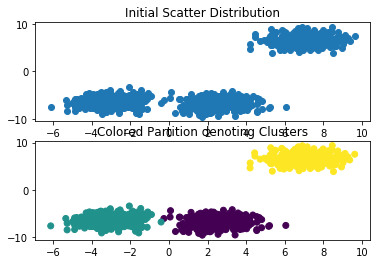

In [5]:
"""
Using SKLearns API for performing Kmeans clustering.
Using sklearn.datasets.make_blobs for generating randomized gaussians
for clustering.

"""

import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs 

# create a dataset sample space that will be used
# to test KMeans. Use function : make_blobs
# 

n_samples = 1000
n_features = 5;
n_clusters = 3;

# aint this sweet 
X, y = make_blobs(n_samples, n_features) 
# X => array of shape [nsamples,nfeatures] ;;; y => array of shape[nsamples]

# X : generated samples, y : integer labels for cluster membership of each sample
# 
# 

# performing KMeans clustering

ret =  KMeans(n_clusters = n_clusters).fit_predict(X)
print(ret)

__, ax = plt.subplots(2)
ax[0].scatter(X[:,0], X[:,1])
ax[0].set_title("Initial Scatter Distribution")
ax[1].scatter(X[:,0], X[:,1], c=ret)
ax[1].set_title("Colored Partition denoting Clusters")
# plt.scatter
plt.show()

